In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.io import loadmat
from tueplots import bundles, figsizes, fontsizes
from tueplots.constants.color import rgb


plt.rcParams.update({"figure.dpi": 150})

# Load Data

In [2]:
data_dir = '..\data\data_for_Meike.mat'
matDf = loadmat(data_dir)['data']
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=matDf.dtype.names).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])

df['Sconfidence'] = df.groupby(['subject', 'block'])['Sreport'].transform(lambda x: np.where(x >= np.mean(x), 1, 0))
df['theta'] = np.absolute(df['dtheta'])


df ['theta_rescaled'] = 0

for subject in df['subject'].unique():
    df.loc[df['subject'] == subject, 'theta_rescaled'] = pd.qcut(
        df.loc[df['subject'] == subject, 'theta'], 
                4, 
                labels=[1, 2, 3, 4]
            ).astype(int)
    

# split by partner type
df_1 = df[df['type'] == 1]
df_2 = df[df['type'] == 2]

# one df for each block
for i in range(1,5):
        exec(f'df_1_{i} = df_1[df_1["block"] == {i}]')
        exec(f'df_2_{i} = df_2[df_2["block"] == {i}]')

Text(0.5, 1.0, 'Block 4')

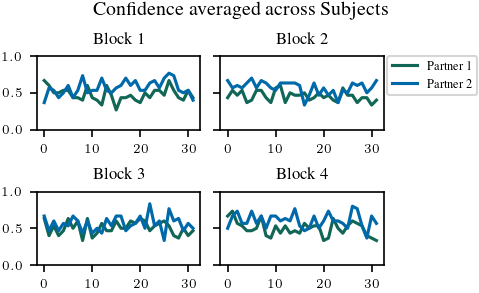

In [96]:
# Plot the data
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=2,
        ncols=2,
        usetex=True,
    )
)
plt.rcParams.update(figsizes.icml2022_half(nrows=2, ncols=2))

fig, axs = plt.subplots(2,2, sharey = True)
fig.suptitle('Confidence averaged across Subjects')

### BLOCK 1 ###
xs_1_1 = np.zeros((32, 30))
xs_2_1 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_1[:,s] = df_1_1[df_1_1['subject'] == subject]['Sconfidence'].values
    xs_2_1[:,s] = df_2_1[df_2_1['subject'] == subject]['Sconfidence'].values
axs[0,0].plot(xs_1_1.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[0,0].plot(xs_2_1.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[0,0].set_title('Block 1')
axs[0,0].set_ylim([0,1])

### BLOCK 2 ###
xs_1_2 = np.zeros((32, 30))
xs_2_2 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_2[:,s] = df_1_2[df_1_2['subject'] == subject]['Sconfidence'].values
    xs_2_2[:,s] = df_2_2[df_2_2['subject'] == subject]['Sconfidence'].values
axs[0,1].plot(xs_1_2.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[0,1].plot(xs_2_2.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[0,1].set_title('Block 2')
axs[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### BLOCK 3 ###
xs_1_3 = np.zeros((32, 30))
xs_2_3 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_3[:,s] = df_1_3[df_1_3['subject'] == subject]['Sconfidence'].values
    xs_2_3[:,s] = df_2_3[df_2_3['subject'] == subject]['Sconfidence'].values
axs[1,0].plot(xs_1_3.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[1,0].plot(xs_2_3.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[1,0].set_title('Block 3')

### BLOCK 4 ###
xs_1_4 = np.zeros((32, 30))
xs_2_4 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_4[:,s] = df_1_4[df_1_4['subject'] == subject]['Sconfidence'].values
    xs_2_4[:,s] = df_2_4[df_2_4['subject'] == subject]['Sconfidence'].values
axs[1,1].plot(xs_1_4.mean(axis=1), color=rgb.mps_green, label='type 1')
axs[1,1].plot(xs_2_4.mean(axis=1), color=rgb.tue_blue, label='type 2')
axs[1,1].set_title('Block 4')





Text(0.5, 1.0, 'Block 4')

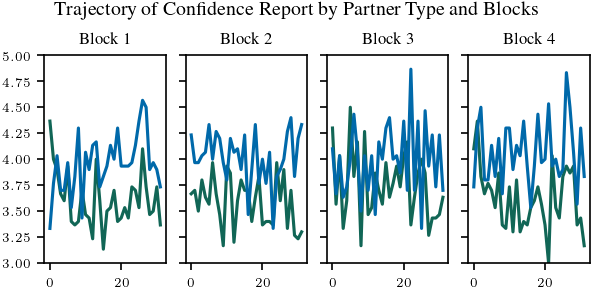

In [98]:
plt.rcParams.update(figsizes.icml2022_half(nrows=1, ncols=4))
fig, axs = plt.subplots(1,4, sharey = True, figsize=(4,2))
fig.suptitle('Trajectory of Confidence Report by Partner Type and Blocks')

### BLOCK 1 ###
xs_1_1 = np.zeros((32, 30))
xs_2_1 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_1[:,s] = df_1_1[df_1_1['subject'] == subject]['Sreport'].values
    xs_2_1[:,s] = df_2_1[df_2_1['subject'] == subject]['Sreport'].values
axs[0].plot(xs_1_1.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[0].plot(xs_2_1.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[0].set_title('Block 1')
axs[0].set_ylim([3,5])

### BLOCK 2 ###
xs_1_2 = np.zeros((32, 30))
xs_2_2 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_2[:,s] = df_1_2[df_1_2['subject'] == subject]['Sreport'].values
    xs_2_2[:,s] = df_2_2[df_2_2['subject'] == subject]['Sreport'].values
axs[1].plot(xs_1_2.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[1].plot(xs_2_2.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[1].set_title('Block 2')
#axs[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### BLOCK 3 ###
xs_1_3 = np.zeros((32, 30))
xs_2_3 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_3[:,s] = df_1_3[df_1_3['subject'] == subject]['Sreport'].values
    xs_2_3[:,s] = df_2_3[df_2_3['subject'] == subject]['Sreport'].values
axs[2].plot(xs_1_3.mean(axis=1), color=rgb.mps_green, label='Partner 1')
axs[2].plot(xs_2_3.mean(axis=1), color=rgb.tue_blue, label='Partner 2')
axs[2].set_title('Block 3')

### BLOCK 4 ###
xs_1_4 = np.zeros((32, 30))
xs_2_4 = np.zeros((32, 30))
for s, subject in enumerate(np.sort(df['subject'].unique())):
    xs_1_4[:,s] = df_1_4[df_1_4['subject'] == subject]['Sreport'].values
    xs_2_4[:,s] = df_2_4[df_2_4['subject'] == subject]['Sreport'].values
axs[3].plot(xs_1_4.mean(axis=1), color=rgb.mps_green, label='type 1')
axs[3].plot(xs_2_4.mean(axis=1), color=rgb.tue_blue, label='type 2')
axs[3].set_title('Block 4')

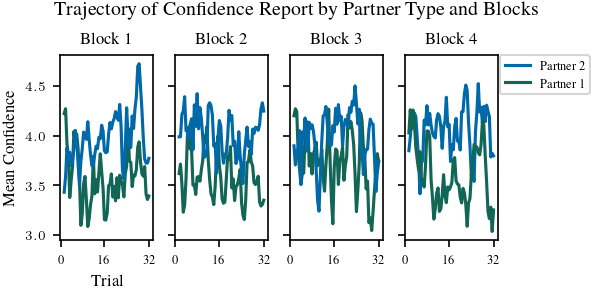

In [173]:
plt.rcParams.update(figsizes.icml2022_half(nrows=2, ncols=4))
fig, axs = plt.subplots(1,4, sharey = True, figsize=(4,2))
fig.suptitle('Trajectory of Confidence Report by Partner Type and Blocks')

### BLOCK 1 ###
axs[0].plot(df_1_1.groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.mps_green, label='Partner 1')
axs[0].plot(df_2_1.groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.tue_blue, label='Partner 2')
axs[0].set_title('Block 1')
axs[0].set_ylabel('Mean Confidence')
axs[0].set_xticks([1, 32, 64], labels=['0', '16', '32'])
axs[0].set_xlabel('Trial')

### BLOCK 2 ###
axs[1].plot(df_1_2.groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.mps_green, label='Partner 1')
axs[1].plot(df_2_2.groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.tue_blue, label='Partner 2')
axs[1].set_title('Block 2')
axs[1].set_xticks([64, 96, 128], labels=['0', '16', '32'])

### BLOCK 3 ###
axs[2].plot(df_1_3.groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.mps_green, label='Partner 1')
axs[2].plot(df_2_3.groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.tue_blue, label='Partner 2')
axs[2].set_title('Block 3')
axs[2].set_xticks([128, 160, 192], labels=['0', '16', '32'])

### BLOCK 4 ###
axs[3].plot(df_2_4.groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.tue_blue, label='Partner 2')
axs[3].plot(df_1_4.groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.mps_green, label='Partner 1')
axs[3].set_title('Block 4')
axs[3].set_xticks([192, 224, 256], labels=['0', '16', '32'])
axs[3].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


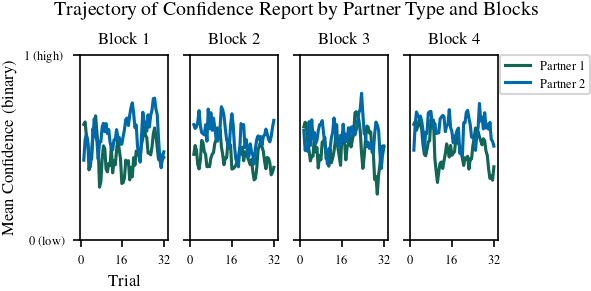

In [163]:
plt.rcParams.update(figsizes.icml2022_full(nrows=2, ncols=4))
fig, axs = plt.subplots(1,4, sharey = True, figsize=(4,2))
fig.suptitle('Trajectory of Confidence Report by Partner Type and Blocks')

### BLOCK 1 ###
axs[0].plot(df_1_1.groupby('trial')['Sconfidence'].mean().rolling(5).mean(), color=rgb.mps_green, label='Partner 1')
axs[0].plot(df_2_1.groupby('trial')['Sconfidence'].mean().rolling(5).mean(), color=rgb.tue_blue, label='Partner 2')
axs[0].set_title('Block 1')
axs[0].set_ylabel('Mean Confidence (binary)')
axs[0].set_ylim([0,1])
axs[0].set_yticks([0,1], labels=['0 (low)', '1 (high)'])
axs[0].set_xticks([1, 32, 64], labels=['0', '16', '32'])
axs[0].set_xlabel('Trial')

### BLOCK 2 ###
axs[1].plot(df_1_2.groupby('trial')['Sconfidence'].mean().rolling(5).mean(), color=rgb.mps_green, label='Partner 1')
axs[1].plot(df_2_2.groupby('trial')['Sconfidence'].mean().rolling(5).mean(), color=rgb.tue_blue, label='Partner 2')
axs[1].set_title('Block 2')
axs[1].set_xticks([64, 96, 128], labels=['0', '16', '32'])

### BLOCK 3 ###
axs[2].plot(df_1_3.groupby('trial')['Sconfidence'].mean().rolling(5).mean(), color=rgb.mps_green, label='Partner 1')
axs[2].plot(df_2_3.groupby('trial')['Sconfidence'].mean().rolling(5).mean(), color=rgb.tue_blue, label='Partner 2')
axs[2].set_title('Block 3')
axs[2].set_xticks([128, 160, 192], labels=['0', '16', '32'])

### BLOCK 4 ###
axs[3].plot(df_1_4.groupby('trial')['Sconfidence'].mean().rolling(5).mean(), color=rgb.mps_green, label='Partner 1')
axs[3].plot(df_2_4.groupby('trial')['Sconfidence'].mean().rolling(5).mean(), color=rgb.tue_blue, label='Partner 2')
axs[3].set_title('Block 4')
axs[3].set_xticks([192, 224, 256], labels=['0', '16', '32'])
axs[3].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


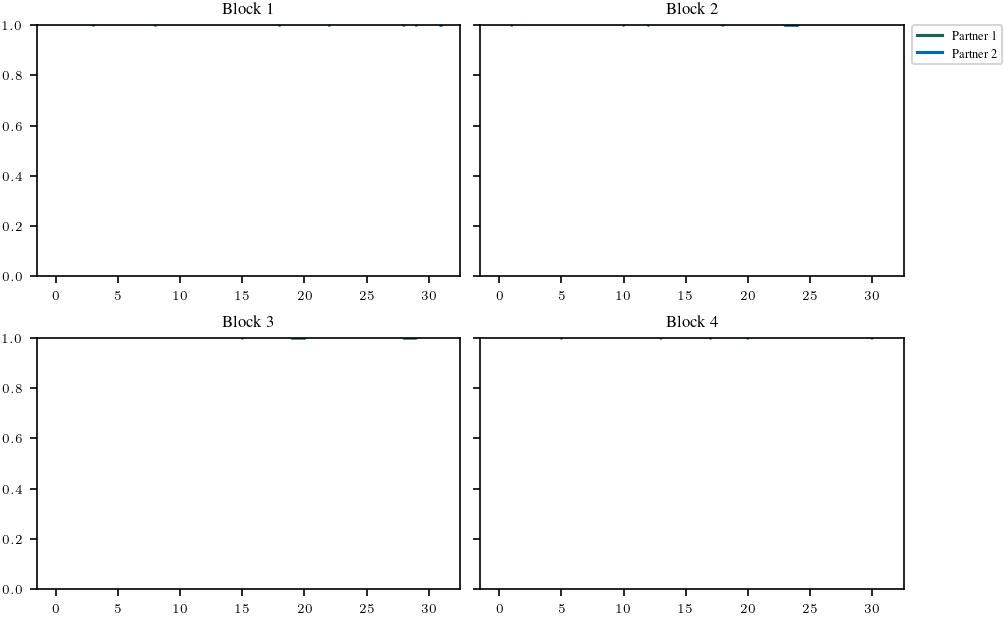

In [107]:
# plot choice distribution of single subject
# Plot the data
plt.rcParams.update(
    bundles.icml2022(
        column="full",
        nrows=2,
        ncols=2,
        usetex=True,
    )
)
fig, ax = plt.subplots(2,2, sharey= True)
subject = 7
ax[0,0].plot(xs_1_1[:,subject], color=rgb.mps_green, label='Partner 1')
ax[0,0].plot(xs_2_1[:,subject], color=rgb.tue_blue, label='Partner 2')
ax[0,0].set_title('Block 1')
ax[0,0].set_ylim([0,1])


ax[0,1].plot(xs_1_2[:,subject], color=rgb.mps_green, label='Partner 1')
ax[0,1].plot(xs_2_2[:,subject], color=rgb.tue_blue, label='Partner 2')
ax[0,1].set_title('Block 2')
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

ax[1,0].plot(xs_1_3[:,subject], color=rgb.mps_green, label='Partner 1')
ax[1,0].plot(xs_2_3[:,subject], color=rgb.tue_blue, label='Partner 2')
ax[1,0].set_title('Block 3')

ax[1,1].plot(xs_1_4[:,subject], color=rgb.mps_green, label='Partner 1')
ax[1,1].plot(xs_2_4[:,subject], color=rgb.tue_blue, label='Partner 2')
ax[1,1].set_title('Block 4')

plt.show()




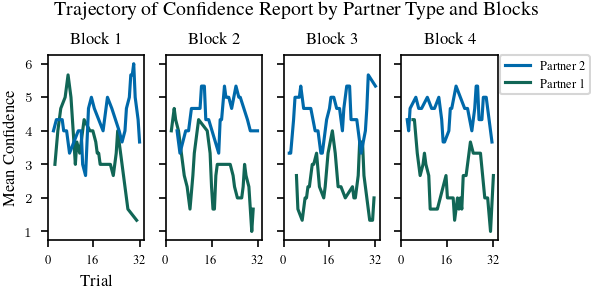

In [27]:

fig, axs = plt.subplots(1,4, sharey = True, figsize=(4,2))
plt.rcParams.update(figsizes.icml2022_half(nrows=2, ncols=4))
plt.rcParams.update(fontsizes.icml2022())
fig.suptitle('Trajectory of Confidence Report by Partner Type and Blocks')
subject = 17
### BLOCK 1 ###
axs[0].plot(df_1_1[df_1_1['subject'] == subject].groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.mps_green, label='Partner 1')
axs[0].plot(df_2_1[df_2_1['subject'] == subject].groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.tue_blue, label='Partner 2')
axs[0].set_title('Block 1')
axs[0].set_ylabel('Mean Confidence')
axs[0].set_xticks([1, 32, 64], labels=['0', '16', '32'])
axs[0].set_xlabel('Trial')

### BLOCK 2 ###
axs[1].plot(df_1_2[df_1_2['subject'] == subject].groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.mps_green, label='Partner 1')
axs[1].plot(df_2_2[df_2_2['subject'] == subject].groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.tue_blue, label='Partner 2')
axs[1].set_title('Block 2')
axs[1].set_xticks([64, 96, 128], labels=['0', '16', '32'])

### BLOCK 3 ###
axs[2].plot(df_1_3[df_1_3['subject'] == subject].groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.mps_green, label='Partner 1')
axs[2].plot(df_2_3[df_2_3['subject'] == subject].groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.tue_blue, label='Partner 2')
axs[2].set_title('Block 3')
axs[2].set_xticks([128, 160, 192], labels=['0', '16', '32'])

### BLOCK 4 ###
axs[3].plot(df_2_4[df_2_4['subject'] == subject].groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.tue_blue, label='Partner 2')
axs[3].plot(df_1_4[df_1_4['subject'] == subject].groupby('trial')['Sreport'].mean().rolling(3).mean(), color=rgb.mps_green, label='Partner 1')
axs[3].set_title('Block 4')
axs[3].set_xticks([192, 224, 256], labels=['0', '16', '32'])
axs[3].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


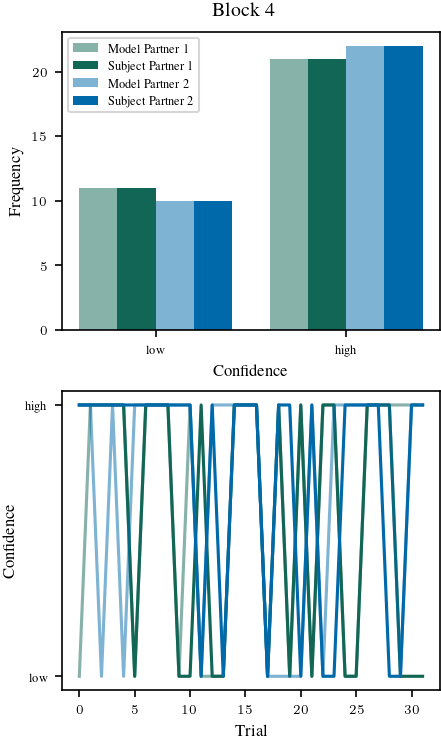

In [ ]:
### BLOCK 4 ###

# Plot the distribution of choices for each subject
labels = ("low", "high")
model_counts_partner1_block4 = (np.sum(model_choices_partner1_block4 == 0), np.sum(model_choices_partner1_block4 == 1))
model_counts_partner2_block4 = (np.sum(model_choices_partner2_block4 == 0), np.sum(model_choices_partner2_block4 == 1))
subject_counts_partner1_block4 = (np.sum(subject_choices_partner1_block4 == 0), np.sum(subject_choices_partner1_block4 == 1))
subject_counts_partner2_block4 = (np.sum(subject_choices_partner2_block4 == 0), np.sum(subject_choices_partner2_block4 == 1))

all_choices_partner1_block4 = {'Model': model_counts_partner1_block4, 'Subject': subject_counts_partner1_block4}
all_choices_partner2_block4 = {'Model': model_counts_partner2_block4, 'Subject': subject_counts_partner2_block4}
all_choices_block4 = {'Model Partner 1': model_counts_partner1_block4, 'Subject Partner 1': subject_counts_partner1_block4, 'Model Partner 2': model_counts_partner2_block4, 'Subject Partner 2': subject_counts_partner2_block4}

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig = plt.figure(figsize=(3,5))
fig.suptitle("Block 4", x=0.55)

ax1 = plt.subplot(211)

for identity, count in all_choices_block1.items():
    offset = width * multiplier
    if identity == 'Model Partner 1':
        alpha = 0.5
        color = rgb.mps_green
    elif identity == 'Model Partner 2':
        alpha = 0.5
        color = rgb.tue_blue
    elif identity == 'Subject Partner 1':
        alpha = 1
        color = rgb.mps_green
    elif identity == 'Subject Partner 2':
        alpha = 1
        color = rgb.tue_blue

    rects = ax1.bar(x + offset, count, width, color=color, alpha=alpha, label=identity)
    multiplier += 1

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Confidence')
ax1.set_xticks(x + (1.5*width), labels)
ax1.legend()

ax2 = plt.subplot(212)

ax2.plot(model_choices_partner1_block4, color=rgb.mps_green, alpha=0.5, label='Model Partner 1')
ax2.plot(subject_choices_partner1_block4, color=rgb.mps_green, label='Subject Partner 1')
ax2.plot(model_choices_partner2_block4, color=rgb.tue_blue, alpha=0.5, label='Model Partner 2')
ax2.plot(subject_choices_partner2_block4, color=rgb.tue_blue, label='Subject Partner 2')
ax2.set_xlabel('Trial')
ax2.set_ylabel('Confidence')
ax2.set_yticks([0,1], labels=['low', 'high'])

plt.show()

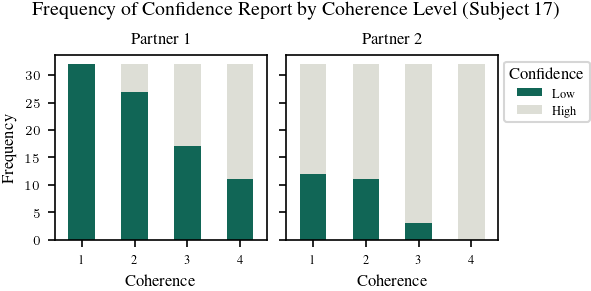

In [26]:

plt.rcParams.update(figsizes.icml2022_half(nrows=1, ncols=2))
# Filter for a specific subject
subject = 17
subject_df = df[df['subject'] == subject]
subject_df_1 = df_1[df_1['subject'] == subject]
subject_df_2 = df_2[df_2['subject'] == subject]

# Calculate frequencies of each combination of theta_rescaled and Sreport
counts_1 = subject_df_1.groupby(['theta_rescaled', 'Sconfidence']).size().unstack(fill_value=0)
counts_2 = subject_df_2.groupby(['theta_rescaled', 'Sconfidence']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(1,2, sharey=True, figsize=(4,2))
counts_1.plot(kind='bar', stacked=True, ax=ax[0], color=[rgb.mps_green, rgb.mps_gray])
counts_2.plot(kind='bar', stacked=True, ax=ax[1], color=[rgb.mps_green, rgb.mps_gray])

ax[0].set_xlabel('Coherence')
ax[0].tick_params(axis='x', labelrotation=0)
ax[1].set_xlabel('Coherence')
ax[1].tick_params(axis='x', labelrotation=0)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Partner 1')
ax[1].set_title('Partner 2')
ax[1].legend(title='Confidence', bbox_to_anchor=(1, 1), loc='upper left', labels=['Low', 'High'])
ax[0].get_legend().remove()
plt.suptitle(f'Frequency of Confidence Report by Coherence Level (Subject {subject})')

plt.show()

COHERENCE HEATMAP

C:\Users\WKL-Oschmann\AppData\Local\Temp\ipykernel_14880\3727801699.py:6: FutureWarning: The provided callable <function mean at 0x0000024FDB447240> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ax = sns.heatmap(pd.pivot_table(df, index='type', columns='theta_rescaled', values='Sconfidence', aggfunc=np.mean), cmap='binary', annot=True, fmt=".2f", vmin=0, vmax=1, cbar_kws={'label': 'Mean Confidence'})


Text(0.5, 1.0, 'Influence of Partner Type and Stimulus Motion Coherence')

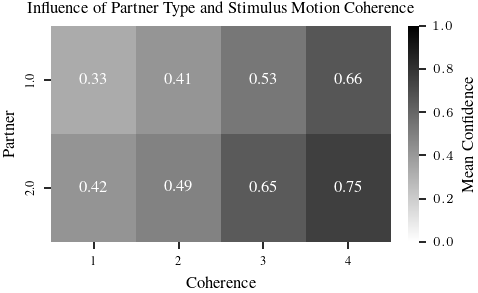

In [29]:
### ALL SUBJECTS ###

plt.rcParams.update(figsizes.icml2022_half(nrows=1, ncols=1))### ALL SUBJECTS ###
plt.rcParams.update(fontsizes.icml2022())

ax = sns.heatmap(pd.pivot_table(df, index='type', columns='theta_rescaled', values='Sconfidence', aggfunc=np.mean), cmap='binary', annot=True, fmt=".2f", vmin=0, vmax=1, cbar_kws={'label': 'Mean Confidence'})
# change labels 
plt.xlabel('Coherence')
plt.ylabel('Partner')
plt.title('Influence of Partner Type and Stimulus Motion Coherence')

C:\Users\WKL-Oschmann\AppData\Local\Temp\ipykernel_14880\2118416372.py:2: FutureWarning: The provided callable <function mean at 0x0000024FDB447240> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ax = sns.heatmap(pd.pivot_table(subject_df, index='type', columns='theta_rescaled', values='Sconfidence', aggfunc=np.mean), cmap='binary', annot=True, fmt=".2f", vmin=0, vmax=1, cbar_kws={'label': 'Mean Confidence'})


Text(0.5, 1.0, 'Influence of Partner Type and Stimulus Motion Coherence')

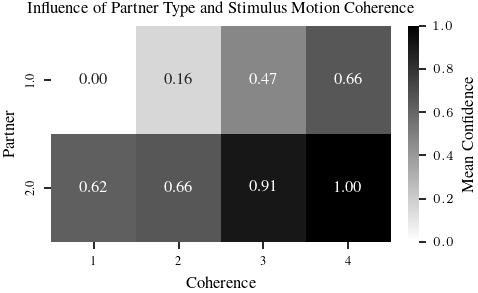

In [30]:
### SINGLE SUBJECT ###
ax = sns.heatmap(pd.pivot_table(subject_df, index='type', columns='theta_rescaled', values='Sconfidence', aggfunc=np.mean), cmap='binary', annot=True, fmt=".2f", vmin=0, vmax=1, cbar_kws={'label': 'Mean Confidence'})
# change labels 
plt.xlabel('Coherence')
plt.ylabel('Partner')
plt.title('Influence of Partner Type and Stimulus Motion Coherence')

C:\Users\WKL-Oschmann\AppData\Local\Temp\ipykernel_1772\2285347353.py:3: FutureWarning: The provided callable <function mean at 0x000001EBFF17B100> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ax = sns.heatmap(pd.pivot_table(subject_df_block123, index='type', columns='theta_rescaled', values='Sconfidence', aggfunc=np.mean), cmap='binary', annot=True, fmt=".2f", vmin=0, vmax=1, cbar_kws={'label': 'Mean Confidence'})


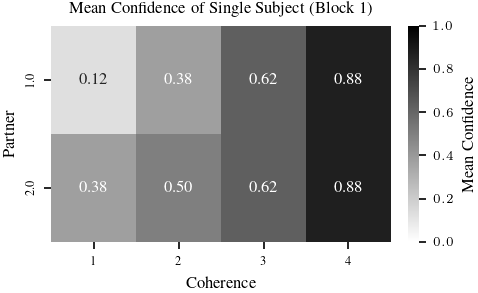

In [183]:
subject_df_block123 = subject_df[subject_df['block'] == 1]

ax = sns.heatmap(pd.pivot_table(subject_df_block123, index='type', columns='theta_rescaled', values='Sconfidence', aggfunc=np.mean), cmap='binary', annot=True, fmt=".2f", vmin=0, vmax=1, cbar_kws={'label': 'Mean Confidence'})
# change labels
plt.xlabel('Coherence')
plt.ylabel('Partner')
plt.title('Mean Confidence of Single Subject (Block 1)')
plt.show()

C:\Users\WKL-Oschmann\AppData\Local\Temp\ipykernel_1772\4201253982.py:3: FutureWarning: The provided callable <function mean at 0x000001EBFF17B100> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ax = sns.heatmap(pd.pivot_table(subject_df_block4, index='type', columns='theta_rescaled', values='Sconfidence', aggfunc=np.mean), cmap='binary', annot=True, fmt=".2f", vmin=0, vmax=1, cbar_kws={'label': 'Mean Confidence'})


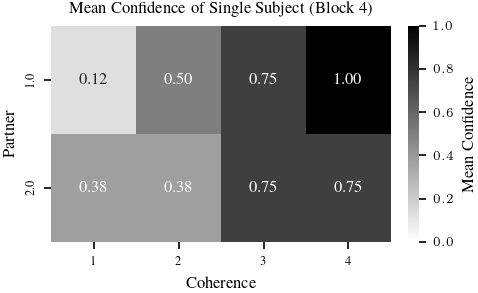

In [184]:
subject_df_block4 = subject_df[subject_df['block'] == 4]

ax = sns.heatmap(pd.pivot_table(subject_df_block4, index='type', columns='theta_rescaled', values='Sconfidence', aggfunc=np.mean), cmap='binary', annot=True, fmt=".2f", vmin=0, vmax=1, cbar_kws={'label': 'Mean Confidence'})
# change labels
plt.xlabel('Coherence')
plt.ylabel('Partner')
plt.title('Mean Confidence of Single Subject (Block 4)')
plt.show()